# Investigate the datatree approach

## Imports

In [13]:
import pyart
from pyart.testing import get_test_data
from datatree import DataTree
import xradar
import xarray as xr

## Read a Sample File Using the Current Approach
We can use one of the sample datasets from pyart

In [38]:
file = get_test_data('110635.mdv')
radar = pyart.io.read_mdv(file)

### Convert to a dictionary of datasets
Let's use the current implementation in xradar - which is regular dictionary of datasets

In [39]:
radar_dict = xradar.convert_to_xradar(radar)

### Plot our dataset

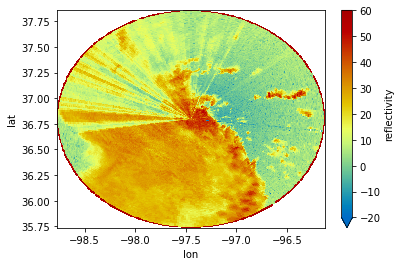

In [42]:
radar_dict["0"].reflectivity.plot(x="lon",
                                  y="lat",
                                  cmap="pyart_HomeyerRainbow",
                                  vmin=-20,
                                  vmax=60);

## Use Datatree Instead
Datatree is a package emerging from the Pangeo ecosystem, meant to work with hierchal datasets (as we are here).

We first need to make sure our dataset is in a regular dictionary - which we can retrieve using the following:

In [164]:
radar_as_dict = dict(radar_dict.items())
radar_as_dict.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])

Each of these datasets includes information about **a single sweep**, but we also want to make sure we have an ***instrument parameters*** dataset which has attributes/data relevant to the entire volume

In [165]:
radar_as_dict["0"]

<xarray.Dataset>
Dimensions:                      (azimuth: 360, range: 983, elevation: 360,
                                  sweep: 1)
Coordinates:
    x                            (azimuth, range) float64 dask.array<chunksize=(360, 983), meta=np.ndarray>
    y                            (azimuth, range) float64 dask.array<chunksize=(360, 983), meta=np.ndarray>
    z                            (azimuth, range) float64 dask.array<chunksize=(360, 983), meta=np.ndarray>
    lat                          (azimuth, range) float64 dask.array<chunksize=(360, 983), meta=np.ndarray>
    lon                          (azimuth, range) float64 dask.array<chunksize=(360, 983), meta=np.ndarray>
    alt                          (azimuth, range) float64 dask.array<chunksize=(360, 983), meta=np.ndarray>
  * azimuth                      (azimuth) float64 0.0 1.0 2.0 ... 358.0 359.0
  * elevation                    (elevation) float64 0.75 0.75 ... 0.75 0.75
  * sweep                        (sweep) int32 0
  * range                        (range) float32 117.9 237.8 ... 1.179e+05
Data variables:
    spectrum_width               (azimuth, range) float32 dask.array<chunksize=(360, 983), meta=np.ndarray>
    differential_phase           (azimuth, range) float32 dask.array<chunksize=(360, 983), meta=np.ndarray>
    velocity                     (azimuth, range) float32 dask.array<chunksize=(360, 983), meta=np.ndarray>
    specific_differential_phase  (azimuth, range) float32 dask.array<chunksize=(360, 983), meta=np.ndarray>
    differential_reflectivity    (azimuth, range) float32 dask.array<chunksize=(360, 983), meta=np.ndarray>
    reflectivity                 (azimuth, range) float32 dask.array<chunksize=(360, 983), meta=np.ndarray>
    normalized_coherent_power    (azimuth, range) float32 dask.array<chunksize=(360, 983), meta=np.ndarray>
    cross_correlation_ratio      (azimuth, range) float32 dask.array<chunksize=(360, 983), meta=np.ndarray>

### Extract the Instrument Parameters

In [166]:
def create_instrument_dict(radar):
    ds = xr.Dataset()
    if radar.instrument_parameters is not None:
        
        sweeps = list(range(radar.nsweeps))
        rays = list(range(radar.nrays))

        ds["sweeps"] = sweeps
        ds["rays"] = rays
        
        ds["latitude"] = (radar.latitude["data"])
        ds["longitude"] = (radar.longitude["data"])
        ds["prt_mode"] = ("sweeps", instrument_dict["prt_mode"]["data"])
        ds["prt"] = ("rays", instrument_dict["prt"]["data"])
        ds["unambiguous_range"] = ("rays", instrument_dict["unambiguous_range"]["data"])
        ds["nyquist_velocity"] = ("rays", instrument_dict["nyquist_velocity"]["data"])
        ds["radar_beam_width_h"] = (instrument_dict["radar_beam_width_h"]["data"])
        ds["radar_beam_width_v"] = (instrument_dict["radar_beam_width_v"]["data"])
        
    return ds

In [180]:
instrument_ds = create_instrument_dict(radar)
instrument_ds

<xarray.Dataset>
Dimensions:             (sweeps: 17, rays: 6120, latitude: 1, longitude: 1,
                         radar_beam_width_h: 1, radar_beam_width_v: 1)
Coordinates:
  * sweeps              (sweeps) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * rays                (rays) int64 0 1 2 3 4 5 ... 6115 6116 6117 6118 6119
  * latitude            (latitude) float64 36.8
  * longitude           (longitude) float64 -97.45
  * radar_beam_width_h  (radar_beam_width_h) float32 1.0
  * radar_beam_width_v  (radar_beam_width_v) float32 1.0
Data variables:
    prt_mode            (sweeps) |S5 b'fixed' b'fixed' ... b'fixed' b'fixed'
    prt                 (rays) float32 0.0008065 0.0008065 ... 0.0008065
    unambiguous_range   (rays) float32 1.18e+05 1.18e+05 ... 1.18e+05 1.18e+05
    nyquist_velocity    (rays) float32 16.52 16.52 16.52 ... 16.52 16.52 16.52

Now that we have our dataset, let's add it to the dictionary

In [181]:
radar_as_dict["instrument_parameters"] = instrument_ds
radar_as_dict.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'instrument_parameters'])

### Create the Datatree
Now that we have our instrument dataset added to our dictionary

In [182]:
tree = DataTree.from_dict(radar_as_dict, name="instrument_parameters")
tree

DataTree(name='instrument_parameters', parent='None', children=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'],
data=<xarray.Dataset>
     Dimensions:             (sweeps: 17, rays: 6120, latitude: 1, longitude: 1,
                              radar_beam_width_h: 1, radar_beam_width_v: 1)
     Coordinates:
       * sweeps              (sweeps) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
       * rays                (rays) int64 0 1 2 3 4 5 ... 6115 6116 6117 6118 6119
       * latitude            (latitude) float64 36.8
       * longitude           (longitude) float64 -97.45
       * radar_beam_width_h  (radar_beam_width_h) float32 1.0
       * radar_beam_width_v  (radar_beam_width_v) float32 1.0
     Data variables:
         prt_mode            (sweeps) |S5 b'fixed' b'fixed' ... b'fixed' b'fixed'
         prt                 (rays) float32 0.0008065 0.0008065 ... 0.0008065
         unambiguous_range   (rays) float32 1.18e+05 1.18e+05 ..

### Plot our Dataset from the Datatree
Let's plot the first sweep from our dataset as we did with the other method

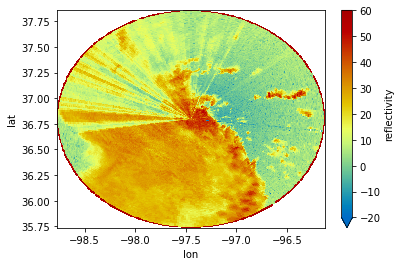

In [177]:
tree["0"].ds.reflectivity.plot(x="lon",
                               y="lat",
                               cmap="pyart_HomeyerRainbow",
                               vmin=-20,
                               vmax=60);